In [1]:
import torch
from PIL import Image
import open_clip
import numpy as np

/home/ezraf/miniconda3/envs/clip/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
model, _, preprocess = open_clip.create_model_and_transforms('ViT-B-16', pretrained='./logs/ViT-B-16_RS_FineTuned_50epochs/checkpoints/epoch_50.pt')
model.eval()  # model in train mode by default, impacts some models with BatchNorm or stochastic depth active
tokenizer = open_clip.get_tokenizer('ViT-B-16')

/home/ezraf/miniconda3/envs/clip/lib/python3.11/site-packages/open_clip/factory.py:129: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path

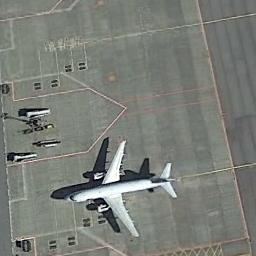

In [3]:
img = Image.open("../datasets/NWPU-Captions/NWPU_images/airplane/airplane_633.jpg")
img.show()

In [4]:
labels = ["An aerial photograph with description: An airplane parked in an open area .",
            "An aerial photograph with description: The wetland consists of bare land and water .",
            "An aerial photograph with description: A brown bulk carrier sails on the blue sea ."]

In [5]:
image = preprocess(img).unsqueeze(0)
text = tokenizer(labels)

with torch.no_grad(), torch.amp.autocast('cuda'):
    image_features = model.encode_image(image)
    text_features = model.encode_text(text)
    image_features /= image_features.norm(dim=-1, keepdim=True)
    text_features /= text_features.norm(dim=-1, keepdim=True)

    text_probs = (100.0 * image_features @ text_features.T).softmax(dim=-1)

print("Label probs:", text_probs)
print("Predicted label: ", labels[np.argmax(text_probs)])

Label probs: tensor([[1.0000e+00, 7.1549e-29, 8.2347e-16]])
Predicted label:  An aerial photograph with description: An airplane parked in an open area .
